In [3]:
import torch
from transformers import AutoTokenizer, AutoModel
from torch import nn
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from codeBert import TripletDataset, custom_collate_fn

In [5]:
class EmbeddingModel(nn.Module):
    def __init__(self, base_model_name, embedding_dim=128):
        super(EmbeddingModel, self).__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(base_model_name)
        self.base_model = AutoModel.from_pretrained(base_model_name)
        self.fc = nn.Linear(self.base_model.config.hidden_size, embedding_dim)

    def forward(self, encodings):
        """
        输入汇编代码的编码，输出128维嵌入向量。
        """
        outputs = self.base_model(**encodings).last_hidden_state.mean(dim=1)  # 平均池化
        embeddings = self.fc(outputs)
        return embeddings

In [6]:
def load_trained_model(model_path, base_model_name="microsoft/codebert-base", device="cuda"):
    """
    加载训练好的模型。
    
    :param model_path: 模型权重文件的路径
    :param base_model_name: 预训练模型的名称
    :param device: 使用的设备（cuda 或 cpu）
    :return: 加载权重的模型
    """
    # 初始化模型
    model = EmbeddingModel(base_model_name)
    
    # 加载模型权重
    model.load_state_dict(torch.load(model_path, map_location=device))
    
    # 将模型移动到指定设备
    model = model.to(device)
    
    # 设置为评估模式
    model.eval()
    return model

In [7]:
def generate_embeddings(model, dataloader, device="cuda"):
    """
    使用加载的模型生成嵌入向量。
    
    :param model: 加载的模型
    :param dataloader: 数据加载器
    :param device: 使用的设备（cuda 或 cpu）
    :return: 生成的嵌入向量列表
    """
    embeddings_list = []
    
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            # 将数据移动到设备
            encodings = {k: v.to(device) for k, v in batch.items()}
            
            # 生成嵌入向量
            embeddings = model(encodings)
            embeddings_list.append(embeddings.cpu())  # 将结果移回 CPU
    
    # 将所有批次的嵌入向量拼接起来
    return torch.cat(embeddings_list, dim=0)

In [14]:
def evaluate_model(model, dataloader, device="cuda"):
    """
    使用加载的模型对测试集进行评估，计算 F1 分数和准确率。
    
    :param model: 加载的模型
    :param dataloader: 数据加载器
    :param device: 使用的设备（cuda 或 cpu）
    """
    all_preds = []
    all_labels = []
    
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            # 将数据移动到设备
            anchor = {k: v.to(device) for k, v in batch["anchor"].items()}
            positive = {k: v.to(device) for k, v in batch["positive"].items()}
            negative = {k: v.to(device) for k, v in batch["negative"].items()}
            
            # 生成嵌入向量
            anchor_embeddings = model(anchor)
            positive_embeddings = model(positive)
            negative_embeddings = model(negative)
            
            # 计算相似度
            pos_sim = torch.nn.functional.cosine_similarity(anchor_embeddings, positive_embeddings)
            neg_sim = torch.nn.functional.cosine_similarity(anchor_embeddings, negative_embeddings)
            
            # 预测结果：1 表示 positive 更相似，0 表示 negative 更相似
            preds = (pos_sim > neg_sim).cpu().numpy().astype(int)
            labels = np.ones_like(preds)  # 假设 positive 对的标签为 1，negative 对的标签为 0
            
            all_preds.extend(preds)
            all_labels.extend(labels)
    
    # 计算评估指标
    f1 = f1_score(all_labels, all_preds)
    accuracy = accuracy_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)

    print(f"F1 Score: {f1:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")

    # 混淆矩阵
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # ROC 曲线
    fpr, tpr, thresholds = roc_curve(all_labels, all_preds)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [12]:
import os
base_dir = "/root/autodl-fs/BinBert"
train_csv_files = [
    os.path.join(base_dir, "DataSet", "train.csv"),
]
test_csv_file = [os.path.join(base_dir, "DataSet", "test_simple.csv")]  # 测试集文件

/tmp/ipykernel_1679/391890417.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


model to device: cuda
Loading data from /root/autodl-fs/BinBert/DataSet/test_simple.csv...
Total triplets loaded: 59907
F1 Score: 0.9959
Accuracy: 0.9918
Recall: 0.9918
Precision: 1.0000


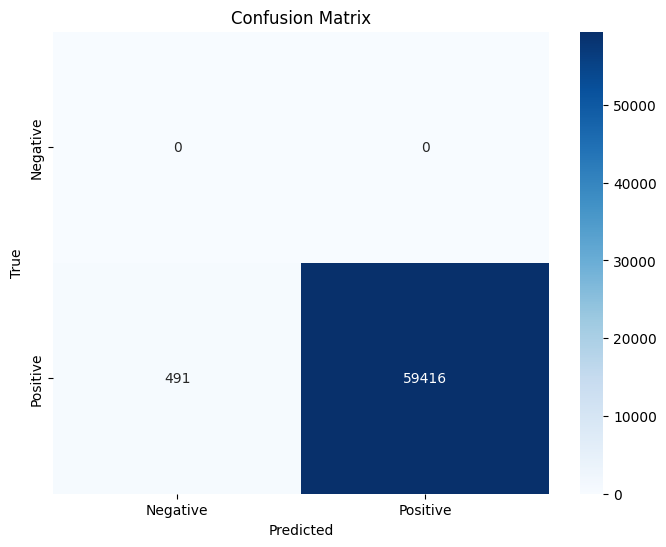

/root/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


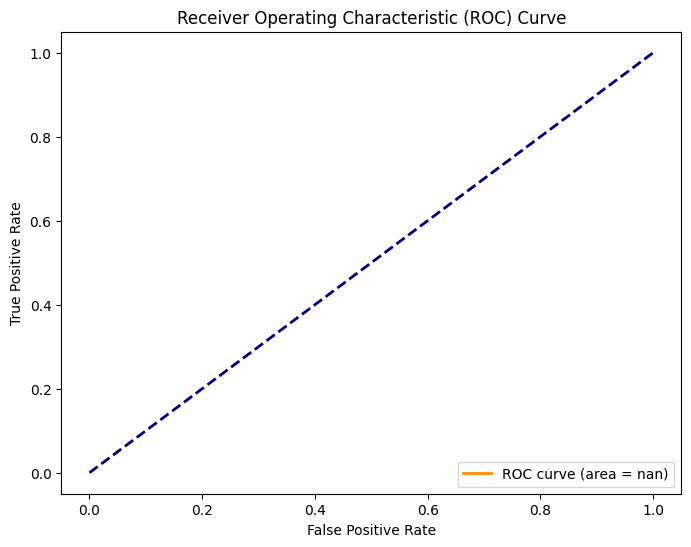

In [15]:
# epoch1
model_path = "/root/autodl-fs/BinBert/models/triplet_model_epoch_1.pth"  # 替换为你的模型路径
device = "cuda" if torch.cuda.is_available() else "cpu"
model = load_trained_model(model_path, base_model_name="microsoft/codebert-base", device=device)
print("model to device:", device)

# 评估
test_dataset = TripletDataset(test_csv_file)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=8, collate_fn=custom_collate_fn)
evaluate_model(model, test_dataloader, device=device)

/tmp/ipykernel_1679/391890417.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


model to device: cuda
Loading data from /root/autodl-fs/BinBert/DataSet/test_simple.csv...
Total triplets loaded: 59907
F1 Score: 0.9965
Accuracy: 0.9931
Recall: 0.9931
Precision: 1.0000


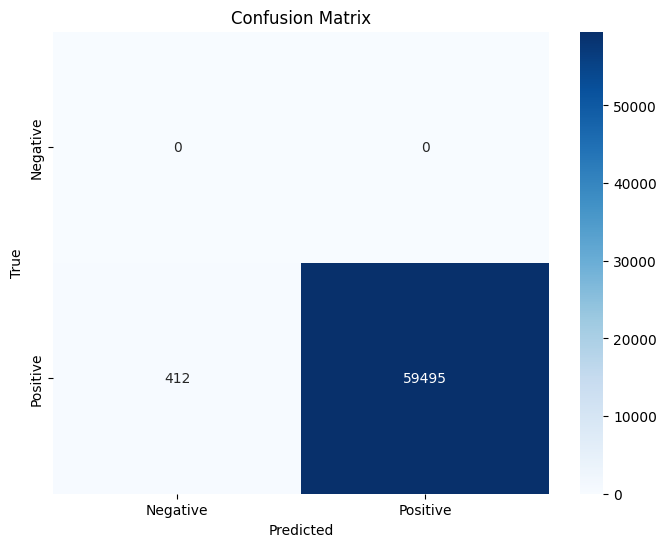

/root/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


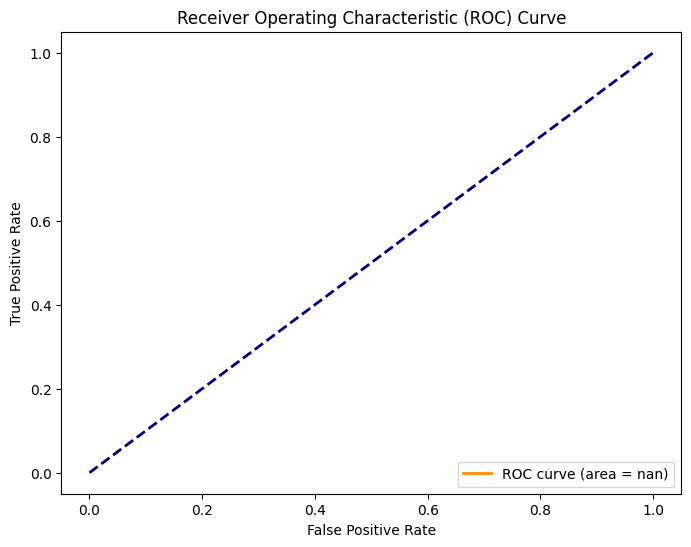

In [16]:
# epoch2
model_path = "/root/autodl-fs/BinBert/models/triplet_model_epoch_2.pth"  # 替换为你的模型路径
device = "cuda" if torch.cuda.is_available() else "cpu"
model = load_trained_model(model_path, base_model_name="microsoft/codebert-base", device=device)
print("model to device:", device)

# 评估
test_dataset = TripletDataset(test_csv_file)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=8, collate_fn=custom_collate_fn)
evaluate_model(model, test_dataloader, device=device)